# Imports

In [50]:
import mlflow

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error

# Configs

In [2]:
pd.set_option("display.max_column", None)

In [3]:
# seta o experimento do mlflow a serem gravadas as runs
mlflow.set_experiment("regressao_weekly_sales_walmart")

<Experiment: artifact_location='file:///home/olini/pes-aplicacoes-ml-desafio6/mlruns/958954269689535938', creation_time=1693183327455, experiment_id='958954269689535938', last_update_time=1693183327455, lifecycle_stage='active', name='regressao_weekly_sales_walmart', tags={}>

# Helper functions

In [4]:
def train_valid_cv_grid_search(X, y, pipeline, grid_param, model_name):
    """Realiza o treinamento e validacao dos modelos utilizando TimeSeries CV e Grid Search,
    logando no mlflow as metricas e melhores parametros encontrados

    Args:
        X: conjunto de features de treino e validacao
        y: variavel resposta de treino e validacao
        pipeline: pipeline do modelo contendo pre-processamento
        grid_param: parametros e seus respectivos valores a serem buscados no grid search
    """
    # inicia run no mlflow
    with mlflow.start_run(run_name=model_name):
        # cria objeto para separacao dos dados do cv
        tscv = TimeSeriesSplit(n_splits=10)
        for i, (train_index, valid_index) in enumerate(tscv.split(X)):
            print(f"Fold {i}")
            # separa dados de treino e validacao baseado nos index do split
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]
            y_train = y.iloc[train_index]
            y_valid = y.iloc[valid_index]
            # realiza o treinamento do modelo utilizando cada uma das combinacoes de parametros
            # em busca da combinacao que retorna a melhor metrica no conjunto de validacao 
            # (Grid Search)
            melhor_rmse = 999999999
            for params in ParameterGrid(grid_param):
                pipeline.set_params(**params)
                pipe_modelo_treinado = pipeline.fit(X_train, y_train)
                y_pred = pipe_modelo_treinado.predict(X_valid)
                rmse = mean_squared_error(y_valid, y_pred, squared=False)
                if rmse < melhor_rmse:
                    melhor_rmse = rmse
                    best_params = params
            
            # printa resultados do fold
            print(f"Melhores parametros: {best_params}")
            print(f"RMSE de validacao = {melhor_rmse}")
            # loga na run do mlflow o rmse de validacao e os melhores parametros encontrados do fold
            mlflow.log_metric(f"rmse_valid_fold_{i}", melhor_rmse)
            dict_log_params = {}
            for key, value in best_params.items():
                dict_log_params[f"{key}_fold_{i}"] = value
            mlflow.log_params(dict_log_params)

# Carrega dados

Dados utilizados: https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data

## Conjunto base de treino

In [5]:
df_train_base = pd.read_csv("data/train.csv")
df_train_base.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Para cada Store e Date, é possível ter N valores de Dept, já que as vendas são separadas por Store-Dept-Date. Como vamos realizar a junção deste dataset com os outros através apenas das colunas Store e Date como uma chave única composta, vamos checar se, para um mesmo Dept, a chave Store-Date é única

In [6]:
df_train_base[["Store", "Date", "Dept"]].value_counts()

Store  Date        Dept
1      2010-02-05  1       1
29     2011-03-25  80      1
                   95      1
                   93      1
                   92      1
                          ..
15     2010-10-01  72      1
                   71      1
                   67      1
                   59      1
45     2012-10-26  98      1
Name: count, Length: 421570, dtype: int64

A chave Store-Date é única entre todos os valores de Dept, sendo possível utilizá-la nos joins sem problemas de duplicação de dados

In [7]:
print(f"Intervalo de datas: [{df_train_base['Date'].min()}, {df_train_base['Date'].max()}]")

Intervalo de datas: [2010-02-05, 2012-10-26]


## Conjunto de features

In [8]:
df_features = pd.read_csv("data/features.csv")
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [9]:
print(f"Intervalo de datas: [{df_features['Date'].min()}, {df_features['Date'].max()}]")

Intervalo de datas: [2010-02-05, 2013-07-26]


## Conjunto de stores

In [10]:
df_stores = pd.read_csv("data/stores.csv")
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Junção dos conjuntos

In [11]:
df_train_feature = pd.merge(df_train_base, df_features, on=["Store", "Date"], how="left", validate="many_to_one")
df_train_feature.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [12]:
df_full = pd.merge(df_train_feature, df_stores, on=["Store"], how="left", validate="many_to_one") 
df_full.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


## Remoção de campos duplicados

As colunas IsHoliday_x e IsHoliday_y, em teoria, possuem os mesmos valores. Vamos garantir que ambas estão de fato duplicadas e deixar apenas uma

In [13]:
# checa se existem instancias que possuem os valores das colunas IsHoliday_x e IsHoliday_y 
# diferentes entre si
df_full[df_full["IsHoliday_x"] != df_full["IsHoliday_y"]]

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size


In [14]:
# remove uma das colunas duplicadas da informacao IsHoliday e renomeia a outra 
df_full.drop(columns=["IsHoliday_y"], inplace=True)
df_full.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)

# Separação dos dados

Para tentar simular um cenário em que temos os dados de teste rotulados para uma medição da performance final do modelo, vamos separar o conjunto total de dados em treino e teste, utilizando o conjunto de treino para treino e validação via cross-validation e o de teste apenas para a medição final de performance.

In [15]:
print(f"Intervalo de datas: [{df_full['Date'].min()}, {df_full['Date'].max()}]")

Intervalo de datas: [2010-02-05, 2012-10-26]


Vamos utilizar 2 anos para o conjunto de treino e validação (2010-02-05 até 2012-02-04) e o restante para teste (2012-02-05, 2012-10-26)

In [16]:
df_train = df_full[df_full["Date"] <= "2012-02-04"]
df_test = df_full[df_full["Date"] >= "2012-02-05"]

In [17]:
print(f"Intervalo de datas de treino: [{df_train['Date'].min()}, {df_train['Date'].max()}]")
print(f"Intervalo de datas de teste: [{df_test['Date'].min()}, {df_test['Date'].max()}]")

Intervalo de datas de treino: [2010-02-05, 2012-02-03]
Intervalo de datas de teste: [2012-02-10, 2012-10-26]


# Análise Descritiva dos Dados

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308959 entries, 0 to 421531
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         308959 non-null  int64  
 1   Dept          308959 non-null  int64  
 2   Date          308959 non-null  object 
 3   Weekly_Sales  308959 non-null  float64
 4   IsHoliday     308959 non-null  bool   
 5   Temperature   308959 non-null  float64
 6   Fuel_Price    308959 non-null  float64
 7   MarkDown1     38527 non-null   float64
 8   MarkDown2     34929 non-null   float64
 9   MarkDown3     36293 non-null   float64
 10  MarkDown4     34312 non-null   float64
 11  MarkDown5     38821 non-null   float64
 12  CPI           308959 non-null  float64
 13  Unemployment  308959 non-null  float64
 14  Type          308959 non-null  object 
 15  Size          308959 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 38.0+ MB


In [19]:
df_train.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,308959.000000,308959.000000,308959.000000,308959.000000,308959.000000,38527.000000,34929.000000,36293.000000,34312.000000,38821.000000,308959.000000,308959.000000,308959.000000
mean,22.180558,44.191132,16028.230955,58.049578,3.218141,6705.718581,7946.238032,5300.414616,3786.708762,5544.450277,169.743148,8.196553,136867.121515
std,12.780538,30.437236,22914.276437,19.044839,0.432690,11805.820775,15441.772632,18152.028839,10038.741362,6174.718284,38.555308,1.865767,60922.444784
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.500000,0.000000,-0.870000,2.000000,135.160000,126.064000,4.261000,34875.000000
25%,11.000000,18.000000,2112.000000,44.130000,2.817000,1003.580000,72.300000,44.160000,169.200000,1798.510000,131.901968,7.241000,93638.000000
50%,22.000000,37.000000,7650.090000,59.120000,3.153000,3312.590000,1402.860000,169.850000,646.200000,3645.000000,182.120157,8.028000,140167.000000
75%,33.000000,72.000000,20209.720000,72.620000,3.594000,6196.770000,7331.950000,659.340000,2084.640000,6418.360000,211.160805,8.625000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.211000,88646.760000,104519.540000,141630.610000,67474.850000,37581.270000,223.900677,14.313000,219622.000000


In [20]:
df_train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
dtype: object

## Limpeza dos dados

### Correção de tipagem das colunas

#### Date

Vamos mudar o formato da coluna Date para datetime

In [21]:
df_train.loc[:, "Date"] = pd.to_datetime(df_train["Date"], format="%Y-%m-%d")

In [22]:
df_train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
dtype: object

### Remoção de dados

#### Weekly_Sales negativo

In [23]:
df_train[df_train["Weekly_Sales"] < 0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
6048,1,47,2010-02-19 00:00:00,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
6049,1,47,2010-03-12 00:00:00,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
6051,1,47,2010-10-08 00:00:00,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
6056,1,47,2011-04-08 00:00:00,-298.00,False,67.84,3.622,NaN,NaN,NaN,NaN,NaN,215.074394,7.682,A,151315
6057,1,47,2011-07-08 00:00:00,-198.00,False,85.83,3.480,NaN,NaN,NaN,NaN,NaN,215.277175,7.962,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12 00:00:00,-0.43,True,27.73,2.773,NaN,NaN,NaN,NaN,NaN,181.982317,8.992,B,118221
419598,45,80,2010-02-19 00:00:00,-0.27,False,31.27,2.745,NaN,NaN,NaN,NaN,NaN,182.034782,8.992,B,118221
419603,45,80,2010-04-16 00:00:00,-1.61,False,54.28,2.899,NaN,NaN,NaN,NaN,NaN,181.692477,8.899,B,118221
419614,45,80,2010-07-02 00:00:00,-0.27,False,76.61,2.815,NaN,NaN,NaN,NaN,NaN,182.318780,8.743,B,118221


Dado que não temos o contexto do negócio para tentar entender melhor estes números negativos de vendas, vamos assumir que os mesmos estão errados e apagá-los da base, já que vendas negativas não parecem fazer sentido e são poucas instâncias.

Existem possibilidades de explicação dos valores negativos, como devoluções de produtos contando negativamente. Mas como não conseguimos confirmar as possíveis causas, seguiremos o caminho de remoção.

In [24]:
df_train = df_train[df_train["Weekly_Sales"] >= 0]

## Análise Exploratória de Dados

In [25]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05 00:00:00,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12 00:00:00,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19 00:00:00,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26 00:00:00,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05 00:00:00,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


### Temperature x Weekly_Sales

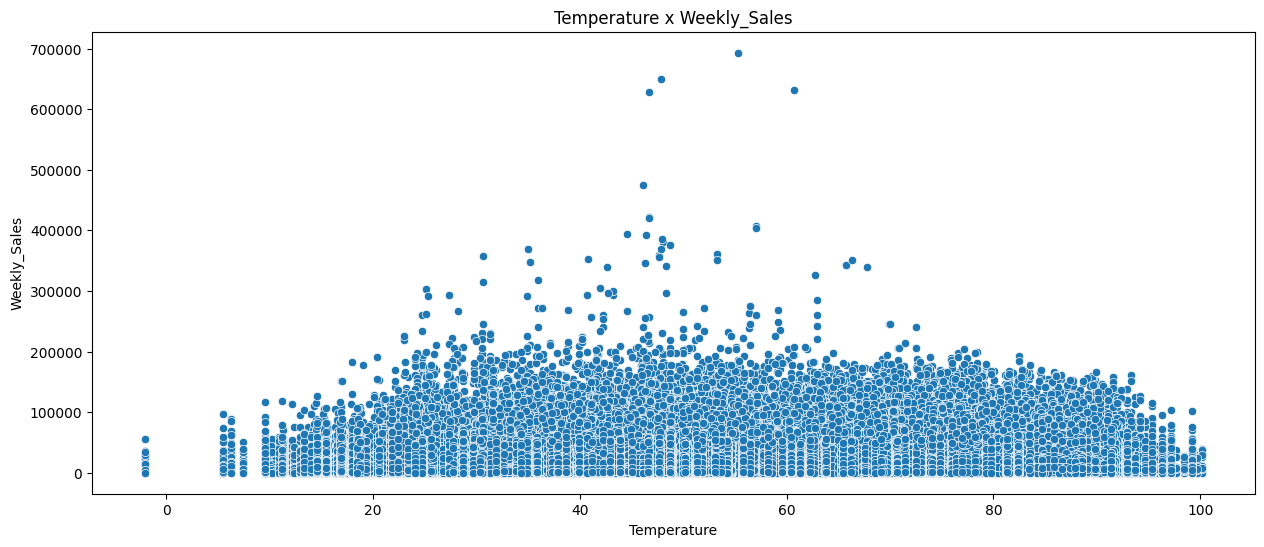

In [26]:
plt.figure(figsize=(15, 6))
sns.scatterplot(df_train, x="Temperature", y="Weekly_Sales").set_title("Temperature x Weekly_Sales");

Podemos ver que não existe uma correlação visual clara entre as duas variáveis. Vamos tentar adicionar a camada de Dept, para enteder se alguns departamentos vendem mais em semanas de temperaturas mais quentes

/home/olini/pes-aplicacoes-ml-desafio6/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


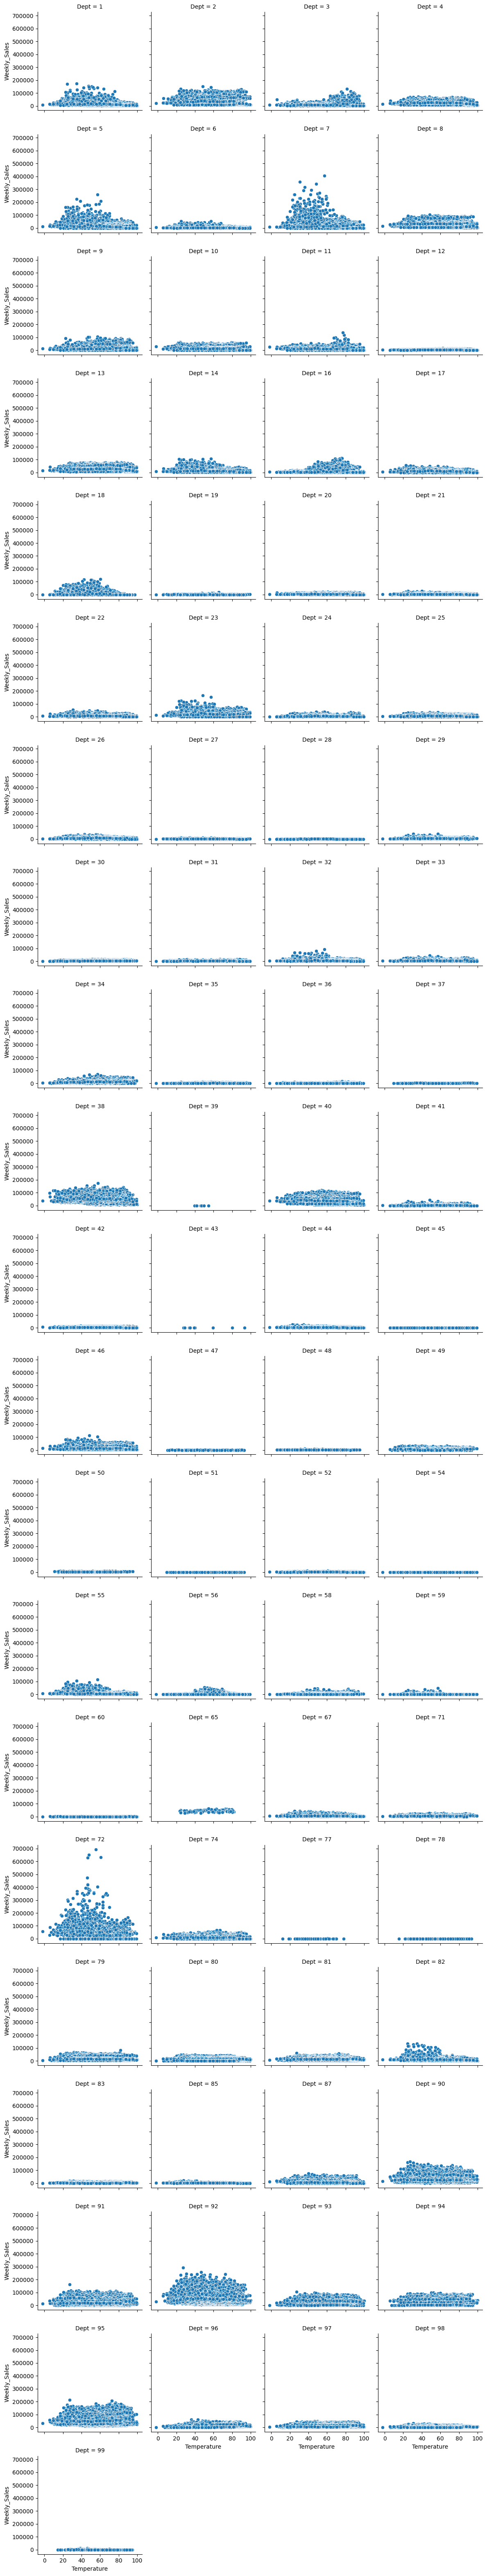

In [27]:
g = sns.FacetGrid(df_train, col="Dept", col_wrap=4)
g.map(sns.scatterplot, "Temperature", "Weekly_Sales");

Realizando a quebra por departamento, podemos visualizar como alguns departamentos variam mais suas vendas mensais em comparação com a temperatura. Como por exemplo o Dept = 7, que possui vendas maiores em semanas com temperaturas entre 20 e 60. Assim como temos departamentos como o Dept = 91 que parece não sofrer alterações nas vendas baseado na temperatura.

### IsHoliday x Weekly_Sales

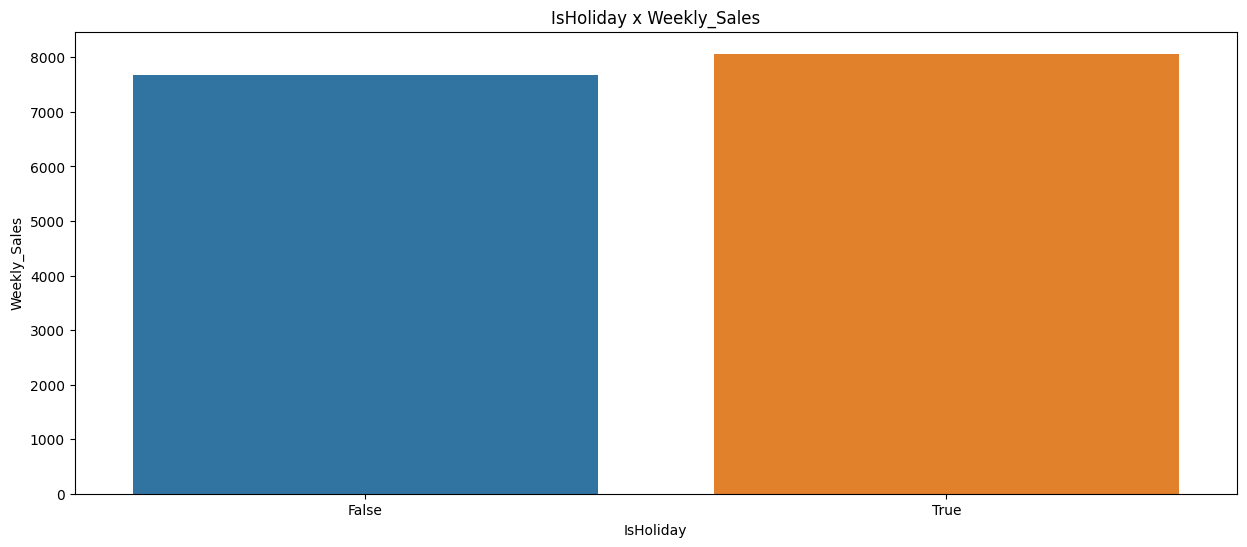

In [28]:
plt.figure(figsize=(15, 6))
df_plot = df_train.groupby("IsHoliday").agg({"Weekly_Sales": "median"}).reset_index()
sns.barplot(df_plot, x="IsHoliday", y="Weekly_Sales").set_title("IsHoliday x Weekly_Sales");

A mediana das vendas mensais em semanas com feriado é mais alta que semanas sem feriado, seguindo a relação imaginada de aumento de consumo nestas épocas.

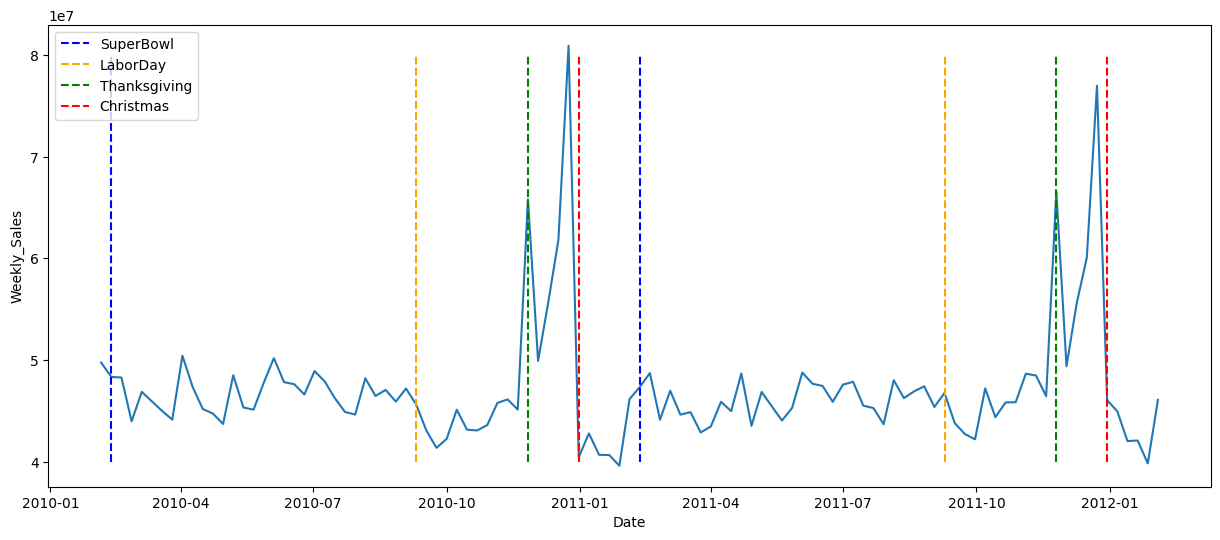

In [29]:
plt.figure(figsize=(15, 6))
df_plot = df_train.groupby(["Date", "IsHoliday"]).agg({"Weekly_Sales": "sum"}).reset_index()
list_date_holiday = df_plot[df_plot["IsHoliday"]==True]["Date"].values
ax = sns.lineplot(df_plot, x="Date", y="Weekly_Sales")#.set_title("Date x Weekly_Sales")
list_holiday = ["SuperBowl", "LaborDay", "Thanksgiving", "Christmas"]
list_color = ["blue", "orange", "green", "red"]
for holiday in list_holiday:
    if holiday == "SuperBowl":
        dates_holiday = list_date_holiday[[0, 4]]
        color = list_color[0]
    elif holiday == "LaborDay":
        dates_holiday = list_date_holiday[[1, 5]]
        color = list_color[1]
    elif holiday == "Thanksgiving":
        dates_holiday = list_date_holiday[[2, 6]]
        color = list_color[2]
    elif holiday == "Christmas":
        dates_holiday = list_date_holiday[[3, 7]]
        color = list_color[3]
    ax.vlines(x = dates_holiday, ymin = 40000000, ymax = 80000000,
            linestyles = "dashed", colors = color, label=holiday)
plt.legend();

No gráfico podemos ver a diferença no volume de vendas na semana do Thanksgiving (quando ocorre a Black Friday) e a semana que antecede o Natal, períodos realmente com alto volume de vendas por contas das festas de fim de ano e épocas de descontos e incentivos para o consumo

### Store Type x Weekly_Sales

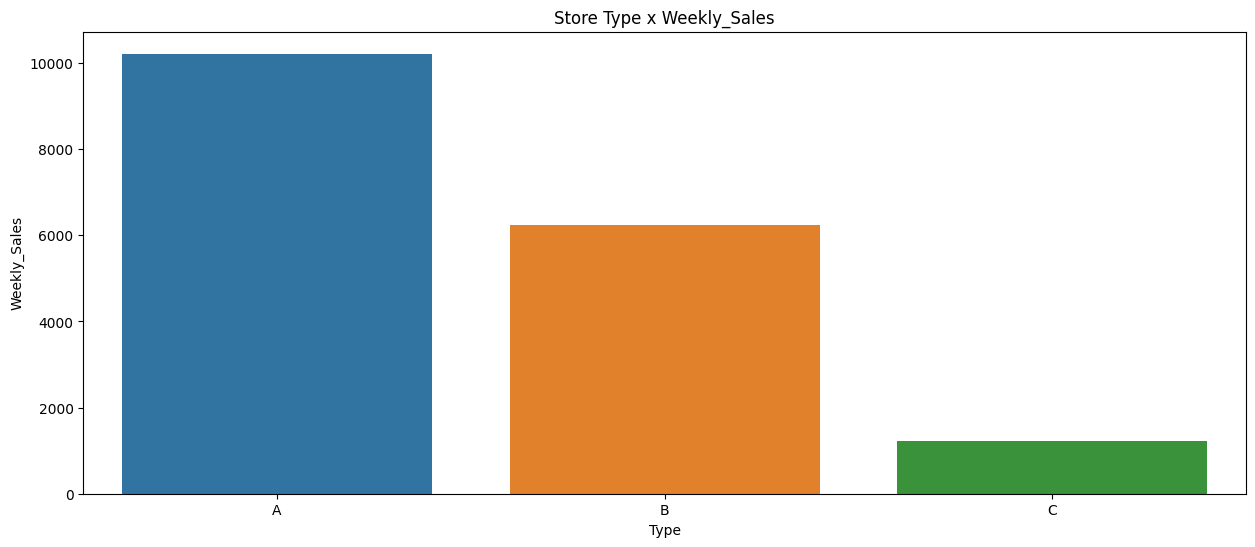

In [30]:
plt.figure(figsize=(15, 6))
df_plot = df_train.groupby("Type").agg({"Weekly_Sales": "median"}).reset_index()
sns.barplot(df_plot, x="Type", y="Weekly_Sales").set_title("Store Type x Weekly_Sales");

Aqui podemos avaliar pela mediana de vendas semanais por tipo de loja que, as lojas do tipo A possuem um perfil de maiores vendas, seguida das lojas tipo B e por fim lojas do tipo C, que apresenta a menor mediana entre as três. Essa classificação provavelmente se dá baseado no volume de vendas da loja de forma direta ou indireta.

# Pré-processamento

## Imputação de dados

### MarkDown1-5 valores nulos

Segundo a descrição dos dados no Kaggle, as colunas de 1 a 5 de MarkDowns devem ser interpretadas como variáveis anonimizadas, não tendo assim o real significado e comportamento das mesmas. Além disso, é dito nesta mesma descrição que estes dados estão disponíveis apenas a partir de Novembro de 2011, e não estão disponíveis para todas as lojas todo o tempo, guardando o valor NaN nos casos de indisponibilidade.

Como os MarkDowns são dados relacionados à promoções e descontos oferecidos pelas lojas em semanas importantes de vendas durante o ano que precedem grandes feriados e, segundo a descrição dos dados, o acerto no volume de vendas nestas semanas é muito importante e esses dados de MarkDown podem ter um poder preditor relevante, vamos tentar aplicar estratégias de imputação nas colunas em instâncias com dados faltantes.

Vamos iniciar checando se os feriados ocorrem sempre na mesma semana do ano:

In [31]:
# vamos criar uma coluna indicando o numero da semana do ano
df_train["week_number"] = df_train["Date"].apply(lambda x: x.isocalendar()[1])
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week_number
0,1,1,2010-02-05 00:00:00,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5
1,1,1,2010-02-12 00:00:00,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6
2,1,1,2010-02-19 00:00:00,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7
3,1,1,2010-02-26 00:00:00,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8
4,1,1,2010-03-05 00:00:00,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9


In [32]:
# vamos verificar se todos os anos, os feriados caem na mesma semana do ano
(
    # primeiro, removemos as linhas duplicadas por week_number e IsHoliday
    df_train[["week_number", "IsHoliday"]].drop_duplicates()
    # apos isso, contamos quantas vezes cada semana aparece. Se uma semana aparecer mais de uma vez
    # significa que em um ano teve feriado na semana e em outro nao
    ["week_number"].value_counts()
)

week_number
5     1
6     1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
1     1
2     1
3     1
32    1
31    1
30    1
17    1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
18    1
29    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
4     1
Name: count, dtype: int64

Podemos ver que os feriados caem sempre na mesma semana do ano (week_number). Como os valores de MarkDowns estão diretamente relacionados às semanas e seus feriados, podemos tentar realizar a imputação dos dados de MarkDown nos baseando na week_number.

Como os dados de MarkDowns estão disponíveis a partir de Novembro de 2011 e nossos dados de treino vão até Fevereiro de 2012, não temos mais de um valor de MarkDown por semana na base. Sendo assim, vamos imputar os valores de MarkDown existentes por Store-Dept-week_number nos dados históricos de MarkDown faltantes por Store-Dept-week_number.

In [33]:
# agora criamos um dataframe auxiliar que contem o valor dos markdowns por semana
df_aux_markdown_per_week = df_train.groupby(["Store", "Dept", "week_number"]).agg(
    week_MarkDown1=("MarkDown1", "max"),
    week_MarkDown2=("MarkDown2", "max"),
    week_MarkDown3=("MarkDown3", "max"),
    week_MarkDown4=("MarkDown4", "max"),
    week_MarkDown5=("MarkDown5", "max")
).reset_index()

In [34]:
df_train = pd.merge(df_train, df_aux_markdown_per_week, on=["Store", "Dept", "week_number"], how="left", validate="many_to_one")

In [35]:
df_train["MarkDown1"] = np.where(
    df_train["MarkDown1"].isnull(),
    df_train["week_MarkDown1"],
    df_train["MarkDown1"]
)
df_train["MarkDown2"] = np.where(
    df_train["MarkDown2"].isnull(),
    df_train["week_MarkDown2"],
    df_train["MarkDown2"]
)
df_train["MarkDown3"] = np.where(
    df_train["MarkDown3"].isnull(),
    df_train["week_MarkDown3"],
    df_train["MarkDown3"]
)
df_train["MarkDown4"] = np.where(
    df_train["MarkDown4"].isnull(),
    df_train["week_MarkDown4"],
    df_train["MarkDown4"]
)
df_train["MarkDown5"] = np.where(
    df_train["MarkDown5"].isnull(),
    df_train["week_MarkDown5"],
    df_train["MarkDown5"]
)

In [36]:
# remove colunas dos markdowns por semana, ja que nao sao mais necessarias
df_train.drop(columns=[
    "week_MarkDown1", "week_MarkDown2", "week_MarkDown3", "week_MarkDown4", "week_MarkDown5"
], inplace=True)

In [37]:
df_train.sample(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week_number
45391,7,23,2010-04-23 00:00:00,9288.84,False,43.07,2.776,NaN,NaN,NaN,NaN,NaN,189.619006,8.963,B,70713,16
207863,29,71,2011-05-06 00:00:00,1808.13,False,53.63,4.078,NaN,NaN,NaN,NaN,NaN,134.514367,9.966,B,93638,18
179666,25,87,2010-02-26 00:00:00,6077.58,False,29.16,2.754,NaN,NaN,NaN,NaN,NaN,204.463087,8.187,B,128107,8
256643,37,60,2011-11-18 00:00:00,765.60,False,66.28,3.308,32.17,5.51,NaN,NaN,1502.49,216.939586,7.716,C,39910,46
285127,41,91,2012-01-13 00:00:00,57492.10,False,27.49,3.077,1934.80,14627.46,112.2,542.89,4044.44,196.733052,6.589,A,196321,2


In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308037 entries, 0 to 308036
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         308037 non-null  int64  
 1   Dept          308037 non-null  int64  
 2   Date          308037 non-null  object 
 3   Weekly_Sales  308037 non-null  float64
 4   IsHoliday     308037 non-null  bool   
 5   Temperature   308037 non-null  float64
 6   Fuel_Price    308037 non-null  float64
 7   MarkDown1     78348 non-null   float64
 8   MarkDown2     71383 non-null   float64
 9   MarkDown3     73997 non-null   float64
 10  MarkDown4     70157 non-null   float64
 11  MarkDown5     78922 non-null   float64
 12  CPI           308037 non-null  float64
 13  Unemployment  308037 non-null  float64
 14  Type          308037 non-null  object 
 15  Size          308037 non-null  int64  
 16  week_number   308037 non-null  int64  
dtypes: bool(1), float64(10), int64(4), object(2)
mem

Para os casos que ainda não possuem dados de MarkDown, vamos agora calcular a mediana de cada por Type-Dept-week_number, buscando um maior preenchimento dos campos

In [39]:
# agora criamos um dataframe auxiliar que contem o valor dos markdowns por semana
df_aux_markdown_per_week_type = df_train.groupby(["Type", "Dept", "week_number"]).agg(
    week_type_MarkDown1=("MarkDown1", "median"),
    week_type_MarkDown2=("MarkDown2", "median"),
    week_type_MarkDown3=("MarkDown3", "median"),
    week_type_MarkDown4=("MarkDown4", "median"),
    week_type_MarkDown5=("MarkDown5", "median")
).reset_index()

In [40]:
df_train = pd.merge(
    df_train, 
    df_aux_markdown_per_week_type, 
    on=["Type", "Dept", "week_number"], 
    how="left", 
    validate="many_to_one"
)

In [41]:
df_train["MarkDown1"] = np.where(
    df_train["MarkDown1"].isnull(),
    df_train["week_type_MarkDown1"],
    df_train["MarkDown1"]
)
df_train["MarkDown2"] = np.where(
    df_train["MarkDown2"].isnull(),
    df_train["week_type_MarkDown2"],
    df_train["MarkDown2"]
)
df_train["MarkDown3"] = np.where(
    df_train["MarkDown3"].isnull(),
    df_train["week_type_MarkDown3"],
    df_train["MarkDown3"]
)
df_train["MarkDown4"] = np.where(
    df_train["MarkDown4"].isnull(),
    df_train["week_type_MarkDown4"],
    df_train["MarkDown4"]
)
df_train["MarkDown5"] = np.where(
    df_train["MarkDown5"].isnull(),
    df_train["week_type_MarkDown5"],
    df_train["MarkDown5"]
)

In [42]:
# remove colunas dos markdowns por semana, ja que nao sao mais necessarias
df_train.drop(columns=[
    "week_type_MarkDown1", "week_type_MarkDown2", "week_type_MarkDown3", "week_type_MarkDown4", 
    "week_type_MarkDown5"
], inplace=True)

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308037 entries, 0 to 308036
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         308037 non-null  int64  
 1   Dept          308037 non-null  int64  
 2   Date          308037 non-null  object 
 3   Weekly_Sales  308037 non-null  float64
 4   IsHoliday     308037 non-null  bool   
 5   Temperature   308037 non-null  float64
 6   Fuel_Price    308037 non-null  float64
 7   MarkDown1     79527 non-null   float64
 8   MarkDown2     76566 non-null   float64
 9   MarkDown3     79398 non-null   float64
 10  MarkDown4     75931 non-null   float64
 11  MarkDown5     79531 non-null   float64
 12  CPI           308037 non-null  float64
 13  Unemployment  308037 non-null  float64
 14  Type          308037 non-null  object 
 15  Size          308037 non-null  int64  
 16  week_number   308037 non-null  int64  
dtypes: bool(1), float64(10), int64(4), object(2)
mem

O restante iremos preencher com 0 para treinamento dos modelos

In [44]:
df_train[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]] = df_train[[
    "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]].fillna(0)

## Padronização e encoding dos dados

In [45]:
# criamos um objeto ColumnTransformer indicando os pre-processamentos a serem utilizados nos dados
# antes dos modelos
column_transformers = ColumnTransformer(
    transformers=[
        ("min_max_scaler", MinMaxScaler(), ["Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", 
                                            "MarkDown3", "MarkDown4", "MarkDown5", "CPI", 
                                            "Unemployment", "Size"]
        ),
        (
            "ordinal_encoder", 
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), 
            ["IsHoliday", "Type"]
        )
    ],
    remainder="passthrough"
)

# Modelos

In [46]:
# nao iremos utilizar como feature a Data
features = [
    "Store", "Dept", "IsHoliday", "Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", 
    "MarkDown3", "MarkDown4", "MarkDown5", "CPI", "Unemployment", "Type", "Size", "week_number"
]
X = df_train[features]
y = df_train["Weekly_Sales"]

## DecisionTree

In [60]:
pipe = Pipeline(
    steps=[
        ("preprocess", column_transformers),
        ("regressor", DecisionTreeRegressor(random_state=4))
    ]
)
grid_param = [
    {
        "regressor__max_depth": [10, 50, 100, None]
    }
]
train_valid_cv_grid_search(X, y, pipe, grid_param, "DecisionTree")

Fold 0
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 13110.528490580902
Fold 1
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 17263.505730850575
Fold 2
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 18108.22968958292
Fold 3
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 13970.114594572604
Fold 4
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 16838.868608142668
Fold 5
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 13499.469956744002
Fold 6
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 12608.699841582054
Fold 7
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 12903.209022377374
Fold 8
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 11468.286762561384
Fold 9
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 9584.538769965617


## Random Forest

In [48]:
pipe = Pipeline(
    steps=[
        ("preprocess", column_transformers),
        ("regressor", RandomForestRegressor(random_state=4))
    ]
)
grid_param = [
    {
        "regressor__max_depth": [10, 50, 100]
    }
]
train_valid_cv_grid_search(X, y, pipe, grid_param, "RandomForest")

Fold 0


Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 11864.402816084881
Fold 1
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 17200.943015946363
Fold 2
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 16146.013910406156
Fold 3
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 12564.53560801077
Fold 4
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 14353.685492920817
Fold 5
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 12821.37318059505
Fold 6
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 11107.86979408633
Fold 7
Melhores parametros: {'regressor__max_depth': 10}
RMSE de validacao = 12691.546196183399
Fold 8
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 10678.216249036754
Fold 9
Melhores parametros: {'regressor__max_depth': 50}
RMSE de validacao = 8508.625908277045


## AdaBoost

In [51]:
pipe = Pipeline(
    steps=[
        ("preprocess", column_transformers),
        ("regressor", AdaBoostRegressor(random_state=4))
    ]
)
grid_param = [
    {
        "regressor__n_estimators": [50, 100],
        "regressor__loss": ["linear", "exponential"],
    }
]
train_valid_cv_grid_search(X, y, pipe, grid_param, "AdaBoost")

Fold 0
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 30695.029624297636
Fold 1
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 25458.641256456354
Fold 2
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 29080.252387010903
Fold 3
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 25392.463528196946
Fold 4
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 28550.358753266595
Fold 5
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 29524.168377031274
Fold 6
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validacao = 24590.949134474267
Fold 7
Melhores parametros: {'regressor__loss': 'linear', 'regressor__n_estimators': 50}
RMSE de validac

# Performance nos dados de teste

Vamos comparar os resultados obtidos e escolher o modelo que será testado com os dados de teste, reproduzindo a produtização do mesmo em um cenário real

In [52]:
results_dt = [
    13110.528490580902, 17263.505730850575, 18108.22968958292, 13970.114594572604, 
    16838.868608142668, 13499.469956744002, 12608.699841582054, 12903.209022377374,
    11468.286762561384, 9584.538769965617
]

results_rf = [
    11864.402816084881, 17200.943015946363, 16146.013910406156, 12564.53560801077,
    14353.685492920817, 12821.37318059505, 11107.86979408633, 12691.546196183399,
    10678.216249036754, 8508.625908277045
]

results_ada = [
    30695.029624297636, 25458.641256456354, 29080.252387010903, 25392.463528196946,
    28550.358753266595, 29524.168377031274, 24590.949134474267, 22027.633429463323,
    28234.72315270809, 26084.01972064866
]

In [53]:
print(f"DecisionTree - RMSE medio: {np.mean(results_dt)}, std: {np.std(results_dt)}")
print(f"RandomForest - RMSE medio: {np.mean(results_rf)}, std: {np.std(results_rf)}")
print(f"AdaBoost - RMSE medio: {np.mean(results_ada)}, std: {np.std(results_ada)}")

DecisionTree - RMSE medio: 13935.545146696011, std: 2561.889359994166
RandomForest - RMSE medio: 12793.721217154754, std: 2443.3955885937694
AdaBoost - RMSE medio: 26963.823936355406, std: 2541.5373675529336


Vemos que os resultados do RandomForest foram os melhores, sendo assim, seguiremos com ele para utilização nos dados de teste

## Imputação nos dados de teste

Dado que realizamos uma imputação customizada nos dados de treino nos campos de MarkDown, vamos realizar a mesma imputação para os dados de teste, porém sem recalcular os valores a serem imputados, visando aplicar o mesmo tratamento utilizado nos dados de treino e não gerar vazamentos de dados (data leakage)

In [56]:
# vamos criar uma coluna indicando o numero da semana do ano
df_test.loc[:, "Date"] = pd.to_datetime(df_test["Date"], format="%Y-%m-%d")
df_test["week_number"] = df_test["Date"].apply(lambda x: x.isocalendar()[1])

# primeiro realizamos a imputacao buscando por dados historicos de MarkDown 
# por Store-Dept-week_number
df_test = pd.merge(
    df_test, 
    df_aux_markdown_per_week, 
    on=["Store", "Dept", "week_number"], 
    how="left", 
    validate="many_to_one"
)

df_test["MarkDown1"] = np.where(
    df_test["MarkDown1"].isnull(),
    df_test["week_MarkDown1"],
    df_test["MarkDown1"]
)
df_test["MarkDown2"] = np.where(
    df_test["MarkDown2"].isnull(),
    df_test["week_MarkDown2"],
    df_test["MarkDown2"]
)
df_test["MarkDown3"] = np.where(
    df_test["MarkDown3"].isnull(),
    df_test["week_MarkDown3"],
    df_test["MarkDown3"]
)
df_test["MarkDown4"] = np.where(
    df_test["MarkDown4"].isnull(),
    df_test["week_MarkDown4"],
    df_test["MarkDown4"]
)
df_test["MarkDown5"] = np.where(
    df_test["MarkDown5"].isnull(),
    df_test["week_MarkDown5"],
    df_test["MarkDown5"]
)
# remove colunas dos markdowns por semana, ja que nao sao mais necessarias
df_test.drop(columns=[
    "week_MarkDown1", "week_MarkDown2", "week_MarkDown3", "week_MarkDown4", "week_MarkDown5"
], inplace=True)

/tmp/ipykernel_24964/1942598885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["week_number"] = df_test["Date"].apply(lambda x: x.isocalendar()[1])


In [57]:
# depois realizamos a imputacao buscando por dados historicos de MarkDown 
# por Store Type-Dept-week_number
df_test = pd.merge(
    df_test, 
    df_aux_markdown_per_week_type, 
    on=["Type", "Dept", "week_number"], 
    how="left", 
    validate="many_to_one"
)

df_test["MarkDown1"] = np.where(
    df_test["MarkDown1"].isnull(),
    df_test["week_type_MarkDown1"],
    df_test["MarkDown1"]
)
df_test["MarkDown2"] = np.where(
    df_test["MarkDown2"].isnull(),
    df_test["week_type_MarkDown2"],
    df_test["MarkDown2"]
)
df_test["MarkDown3"] = np.where(
    df_test["MarkDown3"].isnull(),
    df_test["week_type_MarkDown3"],
    df_test["MarkDown3"]
)
df_test["MarkDown4"] = np.where(
    df_test["MarkDown4"].isnull(),
    df_test["week_type_MarkDown4"],
    df_test["MarkDown4"]
)
df_test["MarkDown5"] = np.where(
    df_test["MarkDown5"].isnull(),
    df_test["week_type_MarkDown5"],
    df_test["MarkDown5"]
)

# remove colunas dos markdowns por semana, ja que nao sao mais necessarias
df_test.drop(columns=[
    "week_type_MarkDown1", "week_type_MarkDown2", "week_type_MarkDown3", "week_type_MarkDown4", 
    "week_type_MarkDown5"
], inplace=True)

In [58]:
# por fim preenchemos os campos que seguem nulos com 0
df_test[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]] = df_test[[
    "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]].fillna(0)

In [59]:
features = [
    "Store", "Dept", "IsHoliday", "Temperature", "Fuel_Price", "MarkDown1", "MarkDown2", 
    "MarkDown3", "MarkDown4", "MarkDown5", "CPI", "Unemployment", "Type", "Size", "week_number"
]
X_test = df_test[features]
y_test = df_test["Weekly_Sales"]

Com os dados de teste pronto, treinamos o modelo com todos os dados de treinamento (sem realizar cv) e medimos sua performance nos dados de teste

In [60]:
pipe = Pipeline(
    steps=[
        ("preprocess", column_transformers),
        ("regressor", RandomForestRegressor(max_depth=50, random_state=4))
    ]
)

pipe.fit(X, y)
y_pred = pipe.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE de teste: {rmse}")

RMSE de teste: 4619.245768708479
